In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import glob
from copy import deepcopy
import numpy as np
import pandas as pd
from PIL import Image

In [2]:
DATASET_PATH = "D:\dataset\kaggle_FlowersRecognition"
df_test = pd.read_csv("test_data.csv")
df_train = pd.read_csv("train_data.csv")
train_paths = df_train['path'].tolist()
test_paths = df_test['path'].tolist()

In [3]:
class class_name_to_label():
    def __init__(self):
        self.dict = {}
        self.inv_dict = {}
        self.num = 0
    def run(self, list):
        labels = []
        for l in list:
            if((l in self.dict.keys()) == False):
                self.dict[l] = self.num
                self.inv_dict[self.num] = l
                self.num += 1
            labels.append(self.dict[l])
        return labels
    def name_to_label(self,name):
        if((name in self.dict.keys()) == True):
            return self.dict[name]
        return -1
    def label_to_name(self,label):
        if((label in self.inv_dict.keys()) == True):
            return self.inv_dict[label]
        return "label not found"
    def num_label(self):
        return len(self.dict)

cntl = class_name_to_label()
train_labels = cntl.run(df_train['class'].tolist())
test_labels = cntl.run(df_test['class'].tolist())
for i in range(cntl.num_label()):
    print(cntl.label_to_name(i))

tulip
dandelion
sunflower
rose
daisy


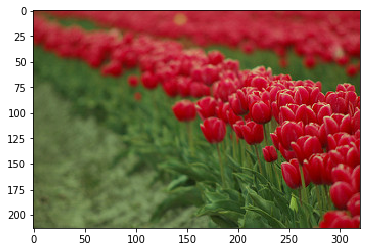

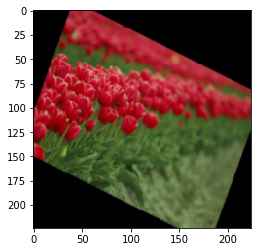

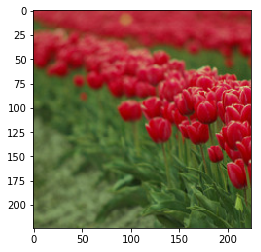

In [4]:
from scipy.ndimage.interpolation import rotate
import random

def horizontal_flip(image):
    image = image[:, ::-1, :]
    return image

def vertical_flip(image, rate=0.5):
    if np.random.rand() < rate:
        image = image[::-1, :, :]
    return image

def random_crop(image, crop_size=(224, 224)):
    h, w, _ = image.shape
    top = 0
    left = 0
    if(h-crop_size[0] > 0):
        top = np.random.randint(0, h - crop_size[0])
    if(w-crop_size[1] > 0):
        left = np.random.randint(0, w - crop_size[1])
    bottom = top + crop_size[0]
    right = left + crop_size[1]
    image = image[top:bottom, left:right, :]
    return image

def scale_augmentation(image, crop_size=224, max_range = 1.2):
    scale_size = np.random.randint(crop_size, crop_size *max_range)  
    image = np.asarray(Image.fromarray(image).resize((scale_size, scale_size), Image.BILINEAR))
    image = random_crop(image, (crop_size, crop_size))
    return image

def random_rotation(image, angle_range=(0, 180)):
    h, w, _ = image.shape
    angle = np.random.randint(*angle_range)
    image = rotate(image, angle)
    image = np.asarray(Image.fromarray(image).resize((w, h), Image.BILINEAR))
    return image

def augmentation(img, widht, height):
    aug_img = np.array(img)
    aug_img = random_rotation(aug_img, angle_range=(0,30))
    if(random.choice([True, False]) == True):
        aug_img = horizontal_flip(aug_img)
    aug_img = scale_augmentation(aug_img, crop_size = widht)
    return aug_img

def short_fit(img, width, height):
    img = np.array(img)
    h, w, _ = img.shape
    if(h < w):
        dest_h = height
        dest_w = int(w * height / h)
        img = np.asarray(Image.fromarray(img).resize((dest_w, dest_h), Image.BILINEAR))
        left = int((dest_w - width)/2)
        right = left + width
        img = img[:, left:right:]
    else:
        dest_w = width
        dest_h = int(h * width / w)
        img = np.asarray(Image.fromarray(img).resize((dest_w, dest_h), Image.BILINEAR))
        top = int((dest_h - height)/2)
        bottom = top + height
        img = img[top:bottom, :, :]
    return img

    
test_file = df_train['path'].tolist()[0]
im = Image.open(test_file)
plt.imshow(im)
plt.show()

a_im = augmentation(im, 224,224)
plt.imshow(a_im)
plt.show()

test_file = df_train['path'].tolist()[0]
im = Image.open(test_file)
a_im = short_fit(im, 224,224)
plt.imshow(a_im)
plt.show()


In [5]:
from keras.utils import Sequence

class MyGenerator(Sequence):
    """Custom generator"""

    def __init__(self, data_paths, data_classes, 
                 batch_size=1, width=224, height=224, ch=3, num_of_class=2, is_validation = False):
        """construction   

        :param data_paths: List of image file  
        :param data_classes: List of class  
        :param batch_size: Batch size  
        :param width: Image width  
        :param height: Image height  
        :param ch: Num of image channels  
        :param num_of_class: Num of classes  
        """

        self.data_paths = data_paths
        self.data_classes = data_classes
        self.length = len(data_paths)
        self.batch_size = batch_size
        self.width = width
        self.height = height
        self.ch = ch
        self.num_of_class = num_of_class
        self.num_batches_per_epoch = int((self.length - 1) / batch_size) + 1
        self.is_validation = is_validation

    def __getitem__(self, idx):
        """Get batch data   

        :param idx: Index of batch  

        :return imgs: numpy array of images 
        :return labels: numpy array of label  
        """
        start_pos = self.batch_size * idx
        end_pos = start_pos + self.batch_size
        if end_pos > self.length:
            end_pos = self.length
        item_paths = self.data_paths[start_pos : end_pos]
        item_classes = self.data_classes[start_pos : end_pos]
        imgs = np.empty((len(item_paths), self.height, self.width, self.ch), dtype=np.float32)
        labels = np.empty((len(item_paths), self.num_of_class), dtype=np.float32)

        for i, (item_path, item_class) in enumerate(zip(item_paths, item_classes)):
            img = Image.open(item_path)
            label = item_class
            if(self.is_validation == False):
                aug_img = augmentation(img, self.width, self.height)
            else:
                aug_img = short_fit(img, self.width, self.height)
            
            imgs[i, :] = aug_img
            labels[i] = np.eye(self.num_of_class)[label]
        return imgs, labels

    def __len__(self):
        """Batch length"""

        return self.num_batches_per_epoch

    def on_epoch_end(self):
        """Task when end of epoch"""
        pass

Using TensorFlow backend.


In [6]:
import os
import time
from keras.applications import MobileNetV2
from keras.applications import MobileNet
from keras.applications import VGG16
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Input
from keras.models import Model
from keras import optimizers

In [7]:
NUM_TRAIN = len(train_paths)
NUM_TEST = len(test_paths)
IMG_SIZE = 224
NUM_BATCH = 32
NUM_EPOCH = 50
NUM_CLASSES = 5

In [8]:
vgg16 = VGG16(
    #input_shape=(IMG_SIZE, IMG_SIZE, 3),
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    include_top=False, 
    weights='imagenet',
    #classes=NUM_CLASSES
)

x=vgg16.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
prediction=Dense(NUM_CLASSES,activation='softmax')(x)
model=Model(inputs=vgg16.input,outputs=prediction)

#model = Model(input=vgg16.input, output=top_model(vgg16.output))

for layer in model.layers[:15]:
    layer.trainable = False

model.compile(
    loss='categorical_crossentropy', 
    #optimizer=Adam(), 
    optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
    metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
val_count = int(len(train_paths) * 0.1)
train_gen = MyGenerator(
                 train_paths[val_count:], 
                 train_labels[val_count:], 
                 batch_size=NUM_BATCH,
                 num_of_class = NUM_CLASSES)
val_gen = MyGenerator(
                 train_paths[:val_count], 
                 train_labels[:val_count], 
                 batch_size=NUM_BATCH,
                 num_of_class = NUM_CLASSES,
                 is_validation = True)

start = time.time()
history = model.fit_generator(
           train_gen, 
           steps_per_epoch=train_gen.num_batches_per_epoch, 
           validation_data=val_gen, 
           validation_steps=val_gen.num_batches_per_epoch,
           epochs=NUM_EPOCH,
           shuffle=True)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
110/110 [==============================] - 223s 2s/step - loss: 0.9523 - acc: 0.6624 - val_loss: 0.5148 - val_acc: 0.8123
Epoch 2/50
110/110 [==============================] - 203s 2s/step - loss: 0.5416 - acc: 0.8166 - val_loss: 0.4958 - val_acc: 0.8483
Epoch 3/50
110/110 [==============================] - 194s 2s/step - loss: 0.3717 - acc: 0.8721 - val_loss: 0.4251 - val_acc: 0.8586
Epoch 4/50
110/110 [==============================] - 192s 2s/step - loss: 0.2667 - acc: 0.9012 - val_loss: 0.4421 - val_acc: 0.8766
Epoch 5/50
110/110 [==============================] - 193s 2s/step - loss: 0.2134 - acc: 0.9209 - val_loss: 0.4093 - val_acc: 0.8843
Epoch 6/50
110/110 [==============================] - 192s 2s/step - loss: 0.1817 - acc: 0.9428 - val_loss: 0.4105 - val_acc: 0.8843
Epoch 7/50
110/110 [==============================] - 192s 2s/step - loss: 0.1361 - acc: 0.9503 - val_loss: 0.4513 - val_acc: 0.8895
Epoch 8/50
110/110 [=

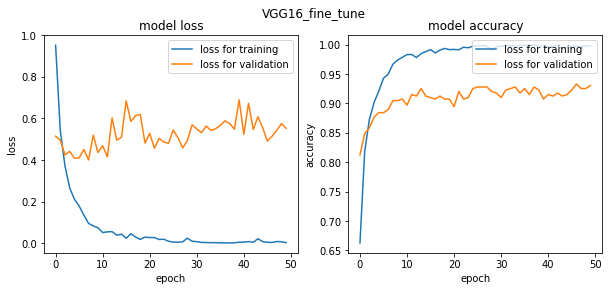

In [10]:
def plot_history(fit):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    plt.title("VGG16_fine_tune")

    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')

    # Plot the loss in the history
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')

plot_history(history)
plt.suptitle('VGG16_fine_tune')
plt.savefig("VGG16_fine_tune.png")
plt.show()

In [11]:
model.save_weights('VGG16_fine_tune.h5')

In [12]:
eval_gen = MyGenerator(
                 test_paths, 
                 test_labels, 
                 batch_size=NUM_BATCH,
                 num_of_class = NUM_CLASSES,
                is_validation = True)
score = model.evaluate_generator(eval_gen)
print(score)

[0.38911041858847495, 0.9259259259259259]


In [13]:
result = model.predict_generator(eval_gen)

est =  daisy
truth =  daisy


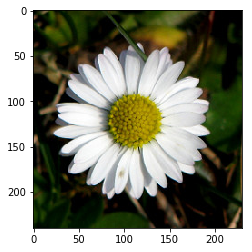

est =  daisy
truth =  daisy


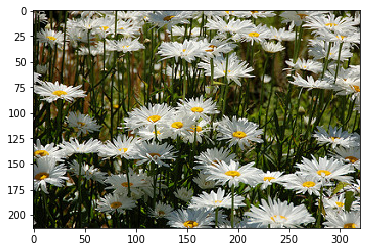

est =  daisy
truth =  daisy


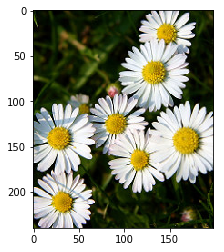

est =  daisy
truth =  daisy


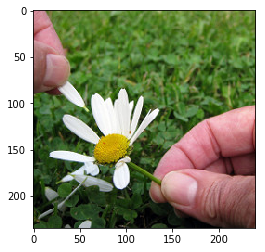

est =  rose
truth =  rose


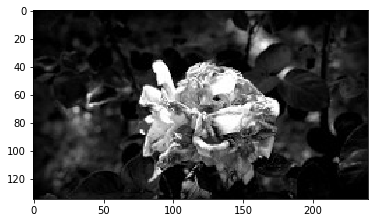

est =  daisy
truth =  daisy


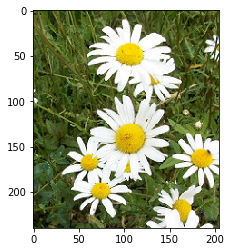

est =  tulip
truth =  tulip


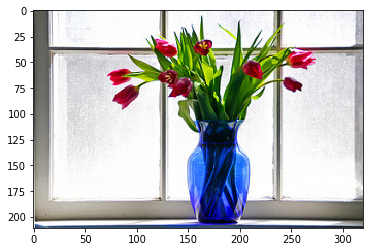

est =  tulip
truth =  tulip


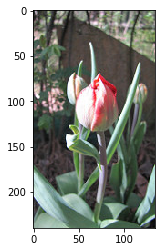

est =  dandelion
truth =  dandelion


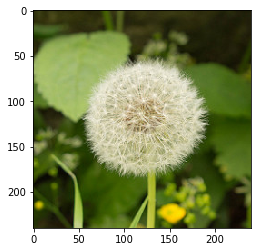

est =  sunflower
truth =  sunflower


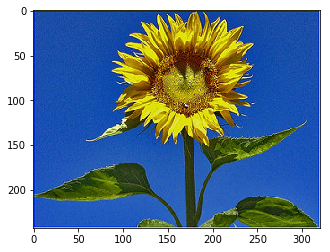

In [14]:
for i in range(10):
    check_id = i
    estimate = np.argmax(result[check_id])
    print("est = ", cntl.label_to_name(estimate))
    print("truth = ", cntl.label_to_name(test_labels[check_id] ))
    test_file = df_test['path'].tolist()[check_id]
    im = Image.open(test_file)
    plt.imshow(im)
    plt.show()